# Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-7.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [n.ma@sheffield.ac.uk](mailto:n.ma@sheffield.ac.uk).

<div class="alert alert-block alert-success" id='ILOs'>
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notebook you should
    
<ul>
<li>Understand the concept of binaural sound localisation</a>
</li> 
<li>Be able to simulate binaural sound
</li>    
<li>Compute binaural cues for sound localisation
</li>
</ul>
</div>

In [2]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd
import scipy.signal as sig
import soundfile as sf
from scipy.io.wavfile import read as wavread
import h5py

# Function to read impulse responses SOFA files
def read_sofa(path, elevation = 0):
    sofa = h5py.File(path, 'r')
    IR_Data = np.asarray(sofa['Data.IR'])
    source_position = sofa['SourcePosition']
    
    # find all indexes for that elevation
    #total_azimuths = np.sum(source_position[:,1] == float(elevation))
    azimuth_indexes = np.where(source_position[:,1] == float(elevation))[0]
    IR_Azimuths = np.zeros(len(azimuth_indexes))
    IR_Data_temp = [[] for i in range(len(azimuth_indexes))]
    for i in range(0, len(azimuth_indexes)):
        IR_Azimuths[i] = round(source_position[azimuth_indexes[i]][0])
        IR_Data_temp[i] = IR_Data[azimuth_indexes[i]]

    IR_Data = np.stack(IR_Data_temp)

    IR_fsHz = sofa['Data.SamplingRate'][0]
    this_elevation = [-60., -50., -40., -30., -20., -10., -0., 10., 20., 30., 40., 50., 60.]
    source_position = (sofa['SourcePosition'])
    for i in range (0, len(this_elevation)):
        this_counter = np.sum(source_position[:,1] == this_elevation[i])
        temp_list = [[] for c in range(this_counter)]
        for k in range(this_counter):
            temp_list[k] = source_position[np.where(source_position[:,1] == this_elevation[i])[0][k]][0]
        #print(this_elevation[i], temp_list)

    return IR_Data, IR_Azimuths, IR_fsHz


<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 1:**
    
<ul>
<li> 
    Load a WAVE file containing speech, e.g. <code>https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/speech_8kHz_murder.wav</code>.
</li>
<li> 
    Load a binaural head-related impulse response (HRIR) to simulate spatial hearing, e.g. KEMAR Anechoic HRIR at 3m: <code>https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/QU_KEMAR_anechoic_3m.sofa</code>. QU KEMAR HRIRs have a resolution of 1 degree, 0:359 anti-clockwise. 
</li>
<li>A common format for representing HRIRs is <a href="https://www.sofaconventions.org/mediawiki/index.php/General_information_on_SOFA">SOFA</a>. Use the <code>read_sofa</code> provided above to load SOFA format HRIRs.
</li>
<li>   
    Simulate a binaural signal by convolving a mono signal with HRIRs, using <code>scipy.signal.fftconvolve</code>
</li> 
</ul>
</div>

In [ ]:
# load speech wave into variable
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{s_file_name} -o {s_file_name} 

s, fs = sf.read(s_file_name)
print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# load impulse response for an anechoic room, 3 metres away
ir_file_name = 'QU_KEMAR_anechoic_3m.sofa'
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{ir_file_name} -o {ir_file_name} 

room_data, room_azimuths, room_fs = read_sofa(ir_file_name)

# Resampel HRTFs to speech fs if required
if fs != room_fs:
    room_data = sig.resample(room_data, int(fs / room_fs * room_data.shape[2]), axis=2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0   966k      0 --:--:-- --:--:-- --:--:--  967k
File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5366k  100 5366k    0     0  5787k      0 --:--:-- --:--:-- --:--:-- 5783k


In [ ]:
# Spatialise speech signal
# QU KEMAR HRTFs have a resolution of 1 degree, 0:359 anti-clockwise
azimuth = 60 # left 60 degrees
azimuth_IR = room_data[azimuth == room_azimuths][0]
sig_left  = sig.fftconvolve(s, azimuth_IR[0])
sig_right = ...

binaural = np.stack((sig_left, sig_right), axis=1)
binaural.shape # (NSAMPLES, 2)


(168730, 2)

As done before we can listen to the signals:

In [ ]:
# listen to the spatialised speech file, Shape=(NCHAN, NSAMPLES).
ipd.Audio(binaural.T, rate=fs)

In [ ]:
# Spatialise speech signal
# QU KEMAR HRTFs have a resolution of 1 degree, 0:359 anti-clockwise
azimuth = 330 # right 60 degrees
...


# listen to the spatialised speech file. Shape=(NCHAN, NSAMPLES).
ipd.Audio(binaural.T, rate=fs)

We could visualise the binaural signals

Text(0.5, 0, 'samples $k$')

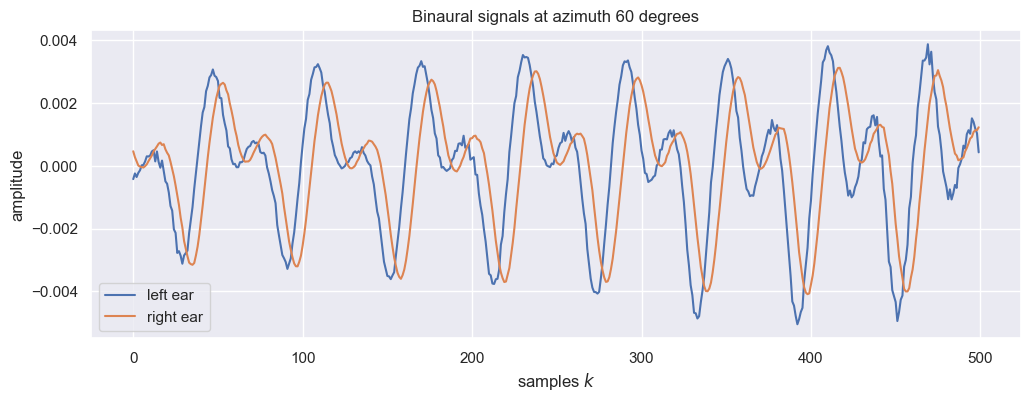

In [ ]:
# We could visualise the binaural signals
binaural_seg = binaural[3500:4000,:]
plt.figure(figsize=(12,4))
plt.plot(binaural_seg)
plt.title('Binaural signals at azimuth ' + str(azimuth) + ' degrees')
plt.ylabel('amplitude')
plt.legend(['left ear', 'right ear'])
plt.xlabel('samples $k$')

## Compute Interaural Time Difference (ITD)

ITD is the difference in arrival time between the two ears. To compute ITD, a common approach is based on cross-correlation of the two ear signals. If the left and right ear signals are represented by $x_L(t)$ and $x_R(t)$:

1.&emsp;Compute cross-correlation:

\begin{equation}
cc[\tau] = \sum_t^T x_L[t] x_R[t-\tau]
\end{equation}


2.&emsp;The lag \tau that maximises $cc[\tau]$ is the ITD.

\begin{equation}
ITD = \argmax_\tau cc[\tau]
\end{equation}

<br>
<a id='task_2'></a>
<div class="alert alert-block alert-info">
    
**Task 2: Compute the ITD on your spatialised signal.**
    
<ul>
<li> Extract a short temporal range from your binaural signal, e.g. 500 ms of audio.
</li>     
<li>
    Compute cross-correlation of the left and right ear signals
</li>
<li>
    Find the lag that miaxmises the cross-correlation function
</li>
</ul>
</div>

Sample delay: -6
ITD (seconds): -0.00075
ITD (microseconds): -750.0


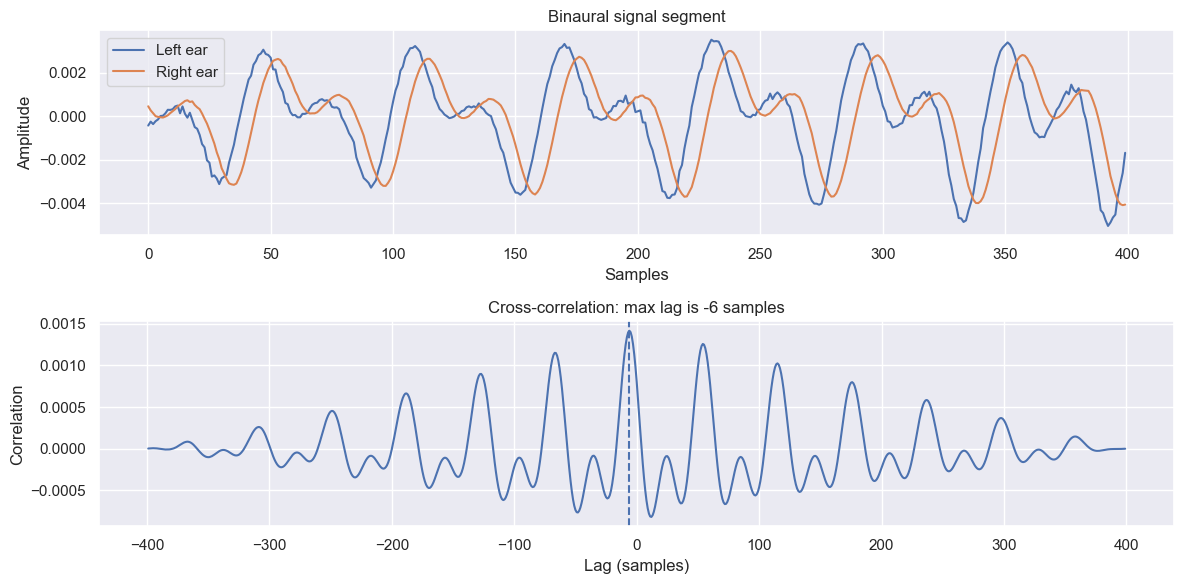

In [ ]:
sig_b = binaural[3500:3900,:]
sig_len = sig_b.shape[0]

# Compute cross-correlation between left and right channels
corr = ...

# Create lag axis in samples
lags = np.arange(-sig_len + 1, sig_len)

# Peak in the cross-correlation tells us the delay
peak_index = ...
sample_delay = ...
itd_seconds = ...

print("Sample delay:", sample_delay)
print("ITD (seconds):", itd_seconds)
print("ITD (microseconds):", itd_seconds * 1e6)

# ---- Plot cross-correlation ----
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(sig_b)
plt.title("Binaural signal segment")
plt.ylabel("Amplitude")
plt.legend(["Left ear", "Right ear"])
plt.xlabel("Samples")
plt.subplot(2,1,2)
plt.plot(lags, corr)
plt.axvline(sample_delay, linestyle='--')
plt.title("Cross-correlation: max lag is " + str(sample_delay) + ' samples')
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

In practice, Generalized Cross-Correlation is often used for computing ITD, which is more robust, frequency-domain enhancement of the raw time-domain cross-correlation method.

## Compute Interaural Level Difference (ILD)

ILD is the difference in sound levels between ears, caused by the head shadow effect. If the sound pressure levels at each ear are $P_L$ and $P_R$:


\begin{equation}
\text{ILD (in dB)} = 20 \log_{10} \frac{P_L}{P_R}
\end{equation}

The sound pressure level is typically the RMS (root mean square) level of the signal.

<br>
<a id='task_3'></a>
<div class="alert alert-block alert-info">
    
**Task 3: Compute the ILD on your spatialised signal**
    
    
<ul>
<li> Typically ILD is frequency depedent, but for simplicity we compute ILD based on time-domain signals
</li>     
</ul>
</div>

In [ ]:
sig_b = binaural[3500:3900,:]
sig_len = sig_b.shape[0]

# Compute Interaural Level Difference (ILD)
rms_left = ...
rms_right = ...
ild_db = ...
print("RMS Left ear:", rms_left)
print("RMS Right ear:", rms_right)
print("ILD (dB):", ild_db)


RMS Left ear: 0.00203302757286466
RMS Right ear: 0.0018067848828305566
ILD (dB): 1.0247364114186432


## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM3502-4502-6502 Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), School of [Computer Science](https://www.sheffield.ac.uk/cs "Open web page of School of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### Contributors
[Ning Ma](https://sheffield.ac.uk/cs/people/academic/ning-ma)